In [1]:
# %%writefile Ind_xxxxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import QUANTAXIS as QA

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat

import EAST.Fetcher_EM as east

from base.JuUnits import excute_for_multidates

E:\PyProjects\IndicatorLab\EAST\Crawler_Block_East.py:41: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2016'
year2 = '2020'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [139]:
# df_all1 = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all2 = load_cache('all_tail_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all = pd.concat([df_all1,df_all2],axis=0).sort_index()

data_ = df_all

year1 = '2016'
year2 = '2022'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [140]:
# 个股情绪

# turnover = data_['volume'] / (data_['lshares'] *100) 

# turnover_mean_month = excute_for_multidates(turnover, lambda x:x.rolling(22).mean(), level='code')
# turnover_mean_week = excute_for_multidates(turnover, lambda x:x.rolling(5).mean(), level='code')
# turnover_unknown = turnover_mean_week/turnover_mean_month

# overnight_ret = excute_for_multidates(data_, lambda x:(x['open']/x['close'].shift(1))-1, level='code')
# turnover_rate = excute_for_multidates(turnover, lambda x: x-x.shift(1), level='code')
# # 指令不平衡(净流入额/总成交额)  代理达成一致意见所需时间
# buy_sell_belance = intraday_df_tmp['bs_balance']

# ret = smpl.get_current_return(data_, 'close')
# ret_std5 = excute_for_multidates(ret, lambda x:x.rolling(5).std(), level='code')

def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        rs = float(x.shape[0])
    else:
        up = (x>0).sum()
        rs = up/down
    rsi=100-100/(1+rs)
    return rsi
    
# *投资者达成一致意见所需时间 = (最高价 - 开盘价) / (收盘价 - 开盘价)
# *相对强弱指标（RSI）：计算公式：RSI=100-100/(1+RS)
   # 相对强度(RS)=一定时期收盘指数涨数的平均值/一定时期收盘指数跌数的平均值，主要和价格的收盘平均值有关，可以表现股价的运动速率。

# RSI_6 = excute_for_multidates(ret, lambda x:x.rolling(6).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_12 = excute_for_multidates(ret, lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_CD = RS_6-RS_12

# *随机指标（KD）
# C为当天的收；
# UP:=HHV(H,20);
# DN:=LLV(L,20);
# RSV:=(C-DN)/(UP-DN)*100;
# K:SMA(RSV,3,1);
# D:SMA(K,3,1);

def calc_kd(df):
    up = df.high.rolling(20).max()
    dn = df.low.rolling(20).min()
    c = df.close
    rsv = (c-dn)/(up-dn) * 100
    return rsv
    
KD = excute_for_multidates(data_, lambda xs:calc_kd(xs), level='code')



# volume





In [141]:
# KD[20:60]

In [142]:
# RSI_CD[24200:24260]

In [143]:
def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        return float(x.shape[0])
    else:
        up = (x>0).sum()
        return up/down
    
excute_for_multidates(ret.loc[(slice(None),'000002'),], lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')

NameError: name 'ret' is not defined

In [ ]:
def get_intraday_indicator_by_code(code,st='2016-03-01',en='2020-12-31',fr=QA.FREQUENCE.FIVE_MIN):
    def calc(varaints_daily):
        close = varaints_daily.close
        ret = (close/close.shift(1) - 1)#.dropna()
        #######指令平衡###########################
        #已实现方差 RealizedVolatility
        net_mf_amount = varaints_daily.amount[ret > 0].sum()
        neg_amount = varaints_daily.amount[ret < 0].sum()
        amount = neg_amount+net_mf_amount
        if amount == 0:
            bs_balance = 0
        else:
            bs_balance = (net_mf_amount/amount)-0.5
        ##########################################
        
        
        # print()
        return bs_balance

    stock_df = smpl.get_data(code, start=st, end=en, gap=None, freq=fr)
    if stock_df is None:
        return None
    stock_df = stock_df.data
    columns = ['close','volume','amount']
    var = stock_df[columns]
    var_unindex = var.reset_index()

    res = var_unindex[columns].groupby(var_unindex.datetime.dt.to_period("D"),group_keys=False).apply(lambda x: calc(x))
    res_df = pd.DataFrame(res.to_list(),
                          index=pd.MultiIndex.from_arrays([res.index.to_timestamp(),[code]*len(res.index)]),
                          columns=['bs_balance'])
    
    return res_df

intraday_df_tmp = pd.DataFrame()
for code in ['002415']:
    res = get_intraday_indicator_by_code(code,dates.min().strftime('%Y-%m-%d'),dates.max().strftime('%Y-%m-%d'))
    if res is None:
        continue
    intraday_df_tmp = pd.concat([intraday_df_tmp,res],axis=0)

In [ ]:
# a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
# a = turnover_unknown.loc[(slice(None),'000001')]
a = KD.loc[(slice(None),'000002'),]
d = a.index.get_level_values(0).unique()
# bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data
bench = data_.loc[(slice(None),'000002'),]

In [ ]:
fig = plt.figure(figsize=(1420/72,320/72))
# a['close'].groupby(level=1).apply(lambda x:x.plot())
a.plot()
# ax2 = plt.gca()
# ax2.plot(range(bench.shape[0]),(0.5*a['close'].loc[(slice(None),'880876')].values+0.5*a['close'].loc[(slice(None),'880877')]).values,linewidth=2,color="red")



ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')


In [ ]:
data_

In [ ]:
a.corr(bench['close'])

In [ ]:
(a['close'].loc[(slice(None),'880811')]).corr(bench['close'])

In [ ]:
(a['close'].loc[(slice(None),'880008')]).corr(a['close'].loc[(slice(None),'880018')])

In [ ]:
a

In [ ]:
a['close'].loc[(slice(None),'880780')]

In [ ]:
# 市场情绪
# n=east.fetch_north_deal_day(direct='north_', start=dates.min(), end=dates.max()).data
# s=east.fetch_north_deal_day(direct='south_', start=dates.min(), end=dates.max()).data
#~ 880780 融资增加 2019开始
#~ 880792 基金增仓 2020
#~ 880793 基金减仓 2020
#~ 880751 昨日跌停# 880863  昨日涨停 # 880876 户数增加 # 880877 户数减少
#~ 880752 昨曾跌停# 880874  昨曾涨停
#~ 880008 全Ａ等权
#~ 880018 主板等权


# 880990 TDX 金融 
# 880005 涨跌家数 收=涨数，开=跌数
# 880006 停板家数 收=涨停数，开=跌停数，高=最大涨停数

# 4.简易市场情绪
# 每日涨停/跌停数

In [ ]:
a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
d = a.index.get_level_values(0).unique()
bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data

fig = plt.figure(figsize=(1420/72,320/72))
a['close'].groupby(level=1).apply(lambda x:x.plot())


ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')


In [3]:
c = data_.loc[(slice(None),'000001'),]
c_ret = smpl.get_current_return(c,'close').dropna()
c_ret_x = c_ret.shift(1).dropna().values
c_ret_y = c_ret[1:].values
c_ret_x = c_ret.shift(1).dropna().values.reshape(-1,1)
c_ret_y = c_ret[1:].values.reshape(-1,1)

# x_train,x_test, y_train, y_test =train_test_split(c_ret_x,c_ret_y,test_size=.1, shuffle=False)

In [153]:
clo = c.close.values
lookback = 5
data_tmp = []
for i in range(len(clo)-5) :
    data_tmp.append(clo[i:i+lookback+1])
data_tmp = np.array(data_tmp)

In [209]:
x = data_tmp[:,:-1].reshape(-1,lookback,1)
x = torch.tensor(x).to(torch.float32)
y = data_tmp[:,-1].reshape(-1,1)
y = torch.tensor(y).to(torch.float32)
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=.1, shuffle=False)
# x_train,x_test, y_train, y_test

In [210]:
x_train.shape, y_train.shape,x_test.shape, y_test.shape

(torch.Size([1091, 5, 1]),
 torch.Size([1091, 1]),
 torch.Size([122, 5, 1]),
 torch.Size([122, 1]))

In [211]:
from torch.utils.data import Dataset,DataLoader

class time_series_dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y[i]
    
train_dataset = time_series_dataset(x_train, y_train)
test_dataset = time_series_dataset(x_test, y_test)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [251]:
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split


# 输入的维度为1，只有Close收盘价
input_dim = 1
# 隐藏层特征的维度
hidden_dim = 4
# 循环的layers
num_stacked_layers = 1
# 预测后一天的收盘价
output_dim = 1
num_epochs = 80


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_stacked_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # batch_size = x.size(0)
        # h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_dim).requires_grad_()
        # c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_dim).requires_grad_()
        # out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_stacked_layers=num_stacked_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [252]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
running_loss = .0

model.train(True)
for t in range(num_epochs):
    for batch_index, batch in enumerate(train_loader):
        x_batch,y_batch = batch[0],batch[1]
    
        output = model(x_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        if batch_index == batch_size-1:
            print("Batch {0} avgLoss: {1}".format(batch_index+1,running_loss/batch_size))
            hist[t] = running_loss
            running_loss = .0

    if t%10==0:
        print("Epoch ", t, "MSE: ", running_loss)


training_time = time.time() - start_time
print("Training time: {}".format(training_time))





Batch 4 avgLoss: 57.178555488586426
Epoch  0 MSE:  6072.643781633582
Batch 4 avgLoss: 1541.4108824658906
Batch 4 avgLoss: 412.756153094042
Batch 4 avgLoss: 346.3999802682665
Batch 4 avgLoss: 317.23311926372844
Batch 4 avgLoss: 258.67371174829896
Batch 4 avgLoss: 408.835570357438
Batch 4 avgLoss: 267.9242196264822
Batch 4 avgLoss: 207.2965535790936
Batch 4 avgLoss: 165.95087510540907
Batch 4 avgLoss: 138.80953196517657
Epoch  10 MSE:  448.062761425972
Batch 4 avgLoss: 130.41942980885506
Batch 4 avgLoss: 121.8382156904554
Batch 4 avgLoss: 112.48476158099947
Batch 4 avgLoss: 98.7842009243468
Batch 4 avgLoss: 87.95709500437079
Batch 4 avgLoss: 74.76948627753154
Batch 4 avgLoss: 62.3008058249834
Batch 4 avgLoss: 53.87609754974255
Batch 4 avgLoss: 46.82908071190468
Batch 4 avgLoss: 42.31251885328675
Epoch  20 MSE:  140.9850280204555
Batch 4 avgLoss: 38.8750055412238
Batch 4 avgLoss: 36.31733544321469
Batch 4 avgLoss: 34.37070517808752
Batch 4 avgLoss: 32.755933954736975
Batch 4 avgLoss: 31.3

In [291]:
model.train(False)
running_loss = .0

predict=[]
original=[]
te
for batch_index, batch in enumerate(test_loader):
    x_batch,y_batch = batch[0],batch[1]

    with torch.no_grad():
        output = model(x_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()
        predict.extend(output.detach().numpy().squeeze().tolist())
        original.extend(y_batch.detach().numpy().squeeze().tolist())

print("validate avgLoss: {0}".format(running_loss/len(test_loader)))
running_loss = .0


validate avgLoss: 3.70405521496169


In [294]:
len(original)

122

In [295]:
predict = pd.DataFrame(predict)
# print(predict)  # 预测值
original = pd.DataFrame(original)
# print(original)  # 真实值

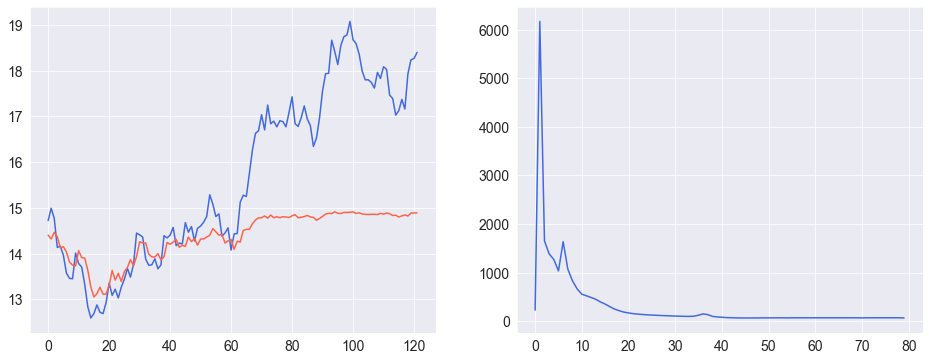

In [296]:

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = plt.plot(list(original.index), original.values, label="Data", color='royalblue')
ax = plt.plot(list(predict.index), predict.values, label="Training Prediction (LSTM)", color='tomato')


plt.subplot(1, 2, 2)
ax = plt.plot(hist, color='royalblue')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()


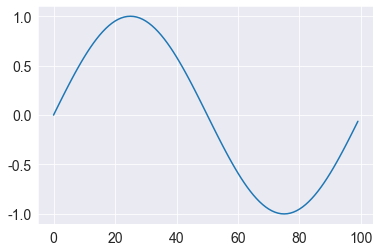

tensor([-0.0290, -0.0744,  0.0840,  0.0089, -0.1195, -0.0694, -0.0895,  0.0019,
         0.0300,  0.0824,  0.0228, -0.1586, -0.0348, -0.0504,  0.0879, -0.0646,
        -0.0562,  0.0881,  0.0188, -0.0628, -0.0239,  0.0712,  0.0167,  0.1379,
         0.0311, -0.0030, -0.0269,  0.0861, -0.0537, -0.0635,  0.1522, -0.0779],
       grad_fn=<SliceBackward0>)
tensor([-0.1247], grad_fn=<ViewBackward0>)
Epoch [1/50], Loss: 0.5206
tensor([ 0.0024, -0.0970,  0.0554,  0.0365, -0.1450, -0.0348, -0.0670,  0.0291,
         0.0088,  0.0566,  0.0038, -0.1314, -0.0506, -0.0661,  0.0566, -0.0424,
        -0.0366,  0.1007,  0.0141, -0.0940, -0.0430,  0.1026, -0.0012,  0.1124,
        -0.0034,  0.0014, -0.0182,  0.1053, -0.0744, -0.0881,  0.1686, -0.1128],
       grad_fn=<SliceBackward0>)
tensor([-0.0276], grad_fn=<ViewBackward0>)
tensor([ 0.0247, -0.1199,  0.0329,  0.0625, -0.1694, -0.0095, -0.0515,  0.0551,
        -0.0043,  0.0371, -0.0121, -0.1147, -0.0672, -0.0832,  0.0317, -0.0311,
        -0.0210,  0

D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([99, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


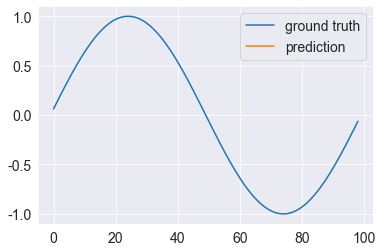

In [115]:

# 设置随机种子，便于复现结果
# torch.manual_seed(1)

# 生成时间序列数据
seq_len = 100
sin_seq = np.sin(np.linspace(0, 2*np.pi, seq_len+1)[:-1])
plt.plot(sin_seq)
plt.show()

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputx):
        output, _ = self.lstm(inputx)
        # output = output[:, -1, :]
        output = output[-1, :]
        print(output)
        output = self.fc(output)
        print(output)
        return output

# 定义模型参数
input_size = 1
hidden_size = 32
output_size = 1
lr = 0.01
epochs = 50

# 构造数据集
X = []
y = []
for i in range(seq_len-1):
    X.append(sin_seq[i])
    y.append(sin_seq[i+1])

X = torch.tensor(X).unsqueeze(1).to(torch.float32)
y = torch.tensor(y).unsqueeze(1).to(torch.float32)

# 初始化模型和优化器
model = LSTMModel(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# 训练模型
for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

# 绘制预测结果
plt.plot(y.squeeze().numpy(), label='ground truth')
plt.plot(pred.detach().numpy(), label='prediction')
plt.legend()
plt.show()

In [106]:
pred.detach()

tensor([-0.0022])